In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'

In [3]:
#model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [10]:
df = sciensano.get_public_spatial_vaccination_data(agg='prov', update=False)
df = df['INCIDENCE']

In [42]:
from covid19model.data.utils import construct_initN

class make_N_vacc_function():
    """A new function to return the right amount of vaccine transitionings at eacht timestep"""
    
    def __init__(self, update=False, agg=None, df_incidences=None, age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')):
        
        if update == False:
            print("We'll just load the data then")
        else:
            
            filter_length = 31
            
            ##########################################
            ## Assign revelant input data to object ##
            ##########################################

            # Input dataframe
            self.df = df_incidences
            # Start- and enddate
            self.df_start = pd.Timestamp(self.df.index.get_level_values('date').min())
            self.df_end = pd.Timestamp(self.df.index.get_level_values('date').max())
            # Number of age groups and spatial patches
            if 'NIS' in self.df.index.names:
                self.G = len(self.df.index.get_level_values('NIS').unique().values)
            self.N = len(age_classes)

            ##########################################################
            ## Step 1: Weekly data to daily data smoothed using EMA ##
            ##########################################################
            
            # 1A: Make a dataframe with the desired format
            iterables=[]
            for index_name in df.index.names:
                if index_name != 'date':
                    iterables += [df.index.get_level_values(index_name).unique()]
                else:
                    iterables += [pd.date_range(start=self.df_start, end=self.df_end, freq='D'),]
            index = pd.MultiIndex.from_product(iterables, names=df.index.names)
            df_new = pd.Series(index=index, name = self.df.name, dtype=float)
            df_new_nf = pd.Series(index=index, name = self.df.name, dtype=float)
            
            # 1B: Loop over (NIS),age,dose
            for age in self.df.index.get_level_values('age').unique():
                for dose in self.df.index.get_level_values('dose').unique():
                    if agg:
                        for NIS in self.df.index.get_level_values('NIS').unique():
                             # Convert weekly to daily data
                            daily_data = df.loc[slice(None), NIS, age, dose].resample('D').bfill().apply(lambda x : x/7)
                            # Apply an exponential moving average
                            daily_data_EMA = daily_data.ewm(span=filter_length, adjust=False).mean()
                            # Assign to new dataframe
                            df_new_nf.loc[slice(None), NIS, age, dose] = daily_data.values
                            df_new.loc[slice(None), NIS, age, dose] = daily_data_EMA.values
                    else:
                        # Convert weekly to daily data
                        daily_data = df.loc[slice(None), age, dose].resample('D').bfill().apply(lambda x : x/7)
                        # Apply an exponential moving average
                        daily_data_EMA = daily_data.ewm(span=filter_length, adjust=False).mean()
                        # Assign to new dataframe
                        df_new.loc[slice(None), age, dose] = daily_data_EMA.values
                        
            self.df = df_new
            self.df_nf = df_new_nf
    
        ############################
        ## Step 2: Age conversion ##
        ############################
        
        # DO
    
    # @lru_cache()
    # get_data(self, t):
    # pass
    
    # __call__(self, ...):
    # pass
            

In [43]:
output = make_N_vacc_function(update=True, agg='prov', df_incidences=df)

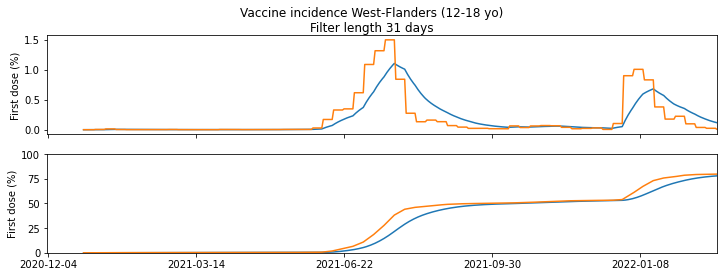

In [44]:
raw_data = output.df
raw_data_nf = output.df_nf

agg = 'prov'
age_classes = raw_data.index.get_level_values('age').unique()
age_class = age_classes[1]
dose = 'A'
NIS = 30000
N = construct_initN(age_classes, agg).loc[NIS,age_class]

series = raw_data.loc[slice(None), NIS, age_class, dose]
series_nf = raw_data_nf.loc[slice(None), NIS, age_class, dose]

fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(12,4))
ax[0].plot(series/N*100)
ax[0].plot(series_nf/N*100)
ax[1].plot(series.cumsum()/N*100)
ax[1].plot(series_nf.cumsum()/N*100)
ax[0].set_xlim([None, pd.Timestamp('2022-03-01')])
ax[1].set_xlim([None, pd.Timestamp('2022-03-01')])
ax[1].set_ylim([0,100])
ax[0].grid(False)
ax[1].grid(False)
ax[0].set_ylabel('First dose (%)')
ax[1].set_ylabel('First dose (%)')
from matplotlib.ticker import MaxNLocator
ax[0].xaxis.set_major_locator(MaxNLocator(5)) 
ax[1].xaxis.set_major_locator(MaxNLocator(5))
fig.suptitle('Vaccine incidence West-Flanders (12-18 yo)\nFilter length 31 days')
plt.show()
plt.close()
fig.savefig('smooth_vaccine_incidence_31days.png', dpi=400)